# TIØ4317 Empirical Mini Project
## Introduction
Hva er dette prosjektet, formål osv. forklare litt

## Data Preprocessing

In [2]:
# Imports
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, het_arch
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tabulate import tabulate

We start by reading the different csv-files that contain the data.

In [3]:
# Define the folder path
data_path = "data/"

# Load datasets
zero_coupon = pd.read_csv(os.path.join(data_path, "zero_coupon_rates.csv"), delimiter=";")
exchange_rates = pd.read_csv(os.path.join(data_path, "usd_nok.csv"), delimiter=";")
inflation = pd.read_csv(os.path.join(data_path, "kpi.csv"), delimiter=";")
osebx = pd.read_csv(os.path.join(data_path, "osebx_prices.csv"), delimiter=";")

# Replace commas with dots in the KPI column and convert to float
inflation["kpi"] = inflation["kpi"].str.replace(",", ".").astype(float)


##### Missing Values
Then, we check for missing values in the data.

In [4]:
datasets = {
    "OSEBX": osebx,
    "Zero Coupon": zero_coupon,
    "Exchange Rates": exchange_rates,
    "Inflation": inflation
}

for name, df in datasets.items():
    missing = df.isnull().sum()
    missing_vars = missing[missing > 0]

    if missing_vars.empty: 
        print(f"{name}: No missing values.")
    else: # If missing values are present, print in which variables it is found. 
        print(f"{name}: Missing values in {', '.join(missing_vars.index)}.")

OSEBX: No missing values.
Zero Coupon: No missing values.
Exchange Rates: No missing values.
Inflation: No missing values.


From the output, we can see that the data does not contain any missing values.

##### Convert to Datetime format
Next, we convert the dates to Datetime format.

Since the inflation data is originally available only on a monthly basis, we apply linear interpolation to estimate daily values.

In [5]:
# Convert Date to Datetime format
osebx["Date"] = pd.to_datetime(osebx["Date"])
zero_coupon["TIME_PERIOD"] = pd.to_datetime(zero_coupon["TIME_PERIOD"])
exchange_rates["TIME_PERIOD"] = pd.to_datetime(exchange_rates["TIME_PERIOD"])
inflation["Date"] = pd.to_datetime(inflation["Date"], format="%YM%m")

# Create a full date range from the first to last available date in your dataset
full_date_range = pd.date_range(start=inflation["Date"].min(), end=inflation["Date"].max(), freq="D")

# Create a DataFrame with daily dates
inflation_daily = pd.DataFrame({"Date": full_date_range})

# Merge with the original inflation data (left join) and forward-fill missing values
inflation_daily = inflation_daily.merge(inflation, on="Date", how="left")
inflation_daily["kpi"] = inflation_daily["kpi"].interpolate(method="linear")

##### Compute log returns for OSEBX
Also, rename columns to ensure that all dataframes have a column named "Date", so that we can merge all datasets on "Date". After having merged all the datasets to one dataframe, we drop all the columns we are not interested in. Consequently, the columns we are left with are "Date", "kpi", "zero_coupon_rate", "usd_nok_exchange_rate", and "log_return".

In [6]:
# Compute log returns
osebx["log_return"] = np.log(osebx["Close"] / osebx["Close"].shift(1))
osebx.dropna(inplace=True)  # Drop the first row where return cannot be calculated

# Rename columns to "Date"
zero_coupon.rename(columns={"TIME_PERIOD": "Date"}, inplace=True)
exchange_rates.rename(columns={"TIME_PERIOD": "Date"}, inplace=True)

# Merge all datasets on 'Date'
df = inflation_daily.merge(zero_coupon, on="Date", how="inner")
df = df.merge(exchange_rates, on="Date", how="inner")
df = df.merge(osebx, on="Date", how="inner") 

df = df.drop(columns=["Close", "High", "Low", "Open", "Volume",
       "FREQ_x", "Frequency_x", "TENOR_x", "Tenor_x", "DECIMALS_x",
       "FREQ_y", "Frequency_y", "BASE_CUR", "Base Currency",
       "QUOTE_CUR", "Quote Currency", "TENOR_y", "Tenor_y", "DECIMALS_y",
       "CALCULATED", "UNIT_MULT", "Unit Multiplier", "COLLECTION",
       "Collection Indicator"])

df.rename(columns={"OBS_VALUE_x": "zero_coupon_rate"}, inplace=True)
df.rename(columns={"OBS_VALUE_y": "usd_nok_exchange_rate"}, inplace=True)

print(df.head())

        Date        kpi  zero_coupon_rate  usd_nok_exchange_rate  log_return
0 2015-03-03  99.225806             1.540                 7.7091    0.005967
1 2015-03-04  99.238710             1.546                 7.7441   -0.012511
2 2015-03-05  99.251613             1.567                 7.7207    0.011992
3 2015-03-06  99.264516             1.639                 7.7917    0.002769
4 2015-03-09  99.303226             1.676                 7.8992   -0.006572


##### Multicollinearity
Check for multicollinearity by computing the correlation matrix.

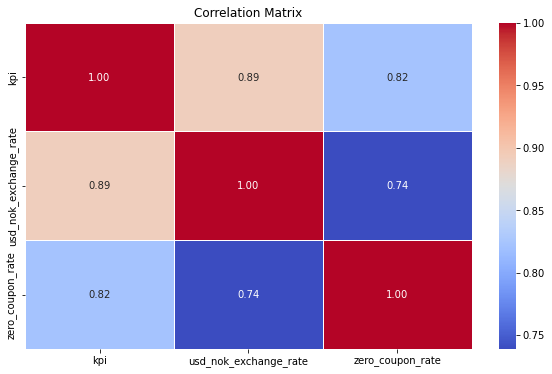

In [7]:
# Compute the correlation matrix
selected_columns = ["kpi", "usd_nok_exchange_rate", "zero_coupon_rate"]
corr_matrix = df[selected_columns].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

We define highly correlated values to have a correlation coefficient >0.9. Because all variables have a correlation coefficient below 0.9, we decide to keep all of the explanatory variables. However, we notice that especially between usd_nok_exchange_rate and kpi and between zero_coupon_rate and kpi the correlation coefficient is close to the boundary. 

##### Stationarity
After having checked for correlation, we check for stationarity by applying the Augmented Dickey-Fuller (ADF) test.

In [8]:
from statsmodels.tsa.stattools import adfuller


# Check for stationarity 
def adf_test(series, var_name):
    result = adfuller(series.dropna())  
    status = "Stationary" if result[1] < 0.05 else "Non-stationary"

    return [var_name, f"{result[0]:.4f}", f"{result[1]:.4f}", status]

# Run ADF tests on all relevant variables
stationarity = [
    adf_test(df["log_return"], "Log Return"),
    adf_test(df["zero_coupon_rate"], "Zero Coupon Rate"),
    adf_test(df["usd_nok_exchange_rate"], "USD/NOK Exchange Rate"),
    adf_test(df["kpi"], "CPI")
]

# Print results in a formatted table
headers = ["Variable", "ADF Statistic", "p-value", "Result"]
print(tabulate(stationarity, headers=headers, tablefmt="pretty"))


+-----------------------+---------------+---------+----------------+
|       Variable        | ADF Statistic | p-value |     Result     |
+-----------------------+---------------+---------+----------------+
|      Log Return       |   -15.8678    | 0.0000  |   Stationary   |
|   Zero Coupon Rate    |    -0.5795    | 0.8755  | Non-stationary |
| USD/NOK Exchange Rate |    -1.4185    | 0.5734  | Non-stationary |
|          CPI          |    1.7132     | 0.9982  | Non-stationary |
+-----------------------+---------------+---------+----------------+


The output indicates that the variables "zero coupon rate," "USD/NOK exchange rate," and "CPI" are non-stationary. To address this, we apply first differences to these columns, ensuring stationarity in our analysis.

In [9]:
# Transform to stationary variables by applying first differences
df["d_kpi"] = df["kpi"].diff()
df["d_zero_coupon_rate"] = df["zero_coupon_rate"].diff()
df["d_usd_nok_exchange_rate"] = df["usd_nok_exchange_rate"].diff()

df = df.dropna()

# Run ADF tests after applying first differences on all relevant variables
post_diff_stationarity = [
    adf_test(df["d_zero_coupon_rate"], "Zero Coupon Rate"),
    adf_test(df["d_usd_nok_exchange_rate"], "USD/NOK Exchange Rate"),
    adf_test(df["d_kpi"], "CPI")
]

# Print results in a table format
headers = ["Variable", "ADF Statistic", "p-value", "Stationarity"]
print(tabulate(post_diff_stationarity, headers=headers, tablefmt="pretty"))


+-----------------------+---------------+---------+--------------+
|       Variable        | ADF Statistic | p-value | Stationarity |
+-----------------------+---------------+---------+--------------+
|   Zero Coupon Rate    |   -45.8067    | 0.0000  |  Stationary  |
| USD/NOK Exchange Rate |   -50.8674    | 0.0000  |  Stationary  |
|          CPI          |    -6.7596    | 0.0000  |  Stationary  |
+-----------------------+---------------+---------+--------------+


From the output, we can see that all the variables now are stationary.

As the explanatory variables used in the Multiple Linear Regression model are also time series of their own, we need to shift all entries as the previous lag. This is to respect the time-dependency of our data. I.E we cannot use values unknown at the time of prediction, we can only use the data we actually have at the time.

In [10]:
#Lag the X-matrix
df["d_kpi"] = df["kpi"].shift(1)
df["d_zero_coupon_rate"] = df["zero_coupon_rate"].shift(1)
df["d_usd_nok_exchange_rate"] = df["usd_nok_exchange_rate"].shift(1)

#Drop first rows as these are noe null:
df = df.dropna()


#### Split into training and testing data

In [11]:
# Define the split percentage (e.g., 80% train, 20% test)
split_idx = int(len(df) * 0.8)

# Split the data
train_df_orig = df.iloc[:split_idx].copy()  # First 80% for training
test_df_orig = df.iloc[split_idx:].copy()   # Last 20% for testing

# Define training and testing sets
X_train_orig, y_train_orig = train_df_orig[['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']], train_df_orig['log_return']
X_test_orig, y_test_orig = test_df_orig[['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']], test_df_orig['log_return']


## Multiple Linear Regression (MLR)


In [12]:
X_train = X_train_orig.copy()
y_train = y_train_orig.copy()

X_test = X_test_orig.copy()
y_test = y_test_orig.copy()

train_df = train_df_orig.copy()
test_df = train_df_orig.copy()

### Autocorrelation
Start by fitting a model to the training set, and then proceed to check for autocorrelation.

In [13]:
# Add constant for intercept
X_train_ols = sm.add_constant(X_train)

# Train OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()

Define a function to test for autocorrelation using Breusch-Godfrey test.

In [14]:
def breusch_godfrey_test(model, nlags=1):
    # Perform the Breusch-Godfrey test
    lm_stat, p_value, f_stat, f_p_value = acorr_breusch_godfrey(model, nlags=nlags)

    # Print the test name and results
    print("Breusch-Godfrey Test for Autocorrelation")
    print("="*40)
    print(f"LM Statistic: {lm_stat:.4f}")
    print(f"P-Value: {p_value:.4f}")
    print(f"F-Statistic: {f_stat:.4f}")
    print(f"F-Test P-Value: {f_p_value:.4f}")
    print("="*40)

    # Interpretation of the p-value
    if p_value < 0.05:
        print("Autocorrelation detected in residuals (reject H0).")
    else:
        print("No significant autocorrelation detected (fail to reject H0).")


In [15]:
# Test if autocorrelation is present in our model         
breusch_godfrey_test(ols_model, nlags=1)

Breusch-Godfrey Test for Autocorrelation
LM Statistic: 3.2375
P-Value: 0.0720
F-Statistic: 3.2346
F-Test P-Value: 0.0723
No significant autocorrelation detected (fail to reject H0).


Since the p-value of the Lagrange Multiplier statistic (LM) is \<0.05 we reject H0. Since the p-value of the F-statistic is also \< 0.05, it suggest that adding lagged variables could improve the model by removing autocorrelation. 

DELETE START
To get an impression of how many lags to use we visualize the partial autocorrelation function (PACF). 

<Figure size 576x360 with 0 Axes>

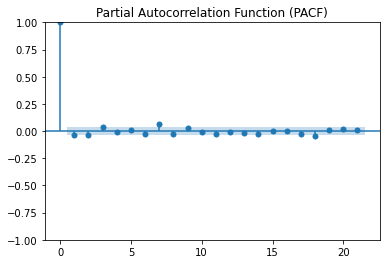

In [ ]:
# Check PACF for 'log_return'
plt.figure(figsize=(8, 5))
plot_pacf(df['log_return'], lags=21, method='ywm')
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

The figure above shows the partial autocorrelation coefficient for each lag, with the blue dashed lines representing the 95% confidence interval. Any bar extending this interval indicates statistical significance. From the figure, we observe that none of the lags appear to be highly significant. Therefore, we will continue adding lags until we no longer detect autocorrelation.

In [17]:
# Added lags
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
variables = ['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']

# Create lagged variables using a loop
for var in variables:
    for lag in lags:
        train_df[f'{var}_lag{lag}'] = train_df[var].shift(lag)

# Drop NaN values introduced by lagging
train_df.dropna(inplace=True)

# Define independent variables dynamically
X = train_df[[col for col in train_df.columns if col.startswith('d_kpi') or 
               col.startswith('d_zero_coupon_rate') or 
               col.startswith('d_usd_nok_exchange_rate')]]


y_train = train_df['log_return']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit the new OLS model
lagged_model = sm.OLS(y_train, X).fit()

# Check for autocorrelation again
breusch_godfrey_test(lagged_model, nlags=1)


Breusch-Godfrey Test for Autocorrelation
LM Statistic: 0.0045
P-Value: 0.9468
F-Statistic: 0.0043
F-Test P-Value: 0.9480
No significant autocorrelation detected (fail to reject H0).


We had to add 28 lags to remove autocorrelation. However, including lagged variables to address autocorrelation introduces some issues. It violates the assumption that the explanatory variables are non-stochastic, and while it address autocorrelation, it also makes the model harder to interpret (SOURCE? Brooks, page 284-285) 

Given these problems, we revisited the PACF and observed that lag 7 and lag 18 appeared to be the most significant. Therefore, we decided to proceed with a model that includes only lag 7 and lag 18, even though autocorrelation is present. While ignoring autocorrelation keeps the coefficient estimates unbiased, the standard error estimates could be wrong. This could lead to unrealiable significance tests and potentially misleading conclusions (SOURCE?, Brooks, p. 276). 

In [18]:
# Define the lags we want to keep
keep_lags = [7, 18]

# Keep only the original variables and the selected lagged variables
columns_to_keep = ['d_kpi', 'd_zero_coupon_rate', 'd_usd_nok_exchange_rate']  # Original columns
columns_to_keep += [f'{var}_lag{lag}' for var in variables for lag in keep_lags]  # Only lags 7 & 18

# Select only the necessary columns
train_df = train_df[columns_to_keep + ['log_return']]

# Drop NaN values introduced by lagging
train_df.dropna(inplace=True)

# Define independent and dependent variables
X = train_df.drop(columns=['log_return'])
y_train = train_df['log_return']

# Add a constant for intercept
X = sm.add_constant(X)

# Fit the new OLS model
keep_lags_model = sm.OLS(y_train, X).fit()

breusch_godfrey_test(keep_lags_model, nlags=1)

Breusch-Godfrey Test for Autocorrelation
LM Statistic: 3.2791
P-Value: 0.0702
F-Statistic: 3.2661
F-Test P-Value: 0.0709
No significant autocorrelation detected (fail to reject H0).


DELETE STOP

### Heteroskedasticity
We continue by testing for heteroskedasticity. This is important because we assume homoskedasticity, which means that all the errors have the same variance. Identifying heteroskedasticity is important because it affects standard errors, confidence intervals, and hypothesis testing reliability in OLS regression.

We test if the homoskedasticity assumption holds by using the ARCH test, as it is well-suited for time-series data because it detects time-dependent variance. 

In [19]:
residuals = keep_lags_model.resid

arch_test = het_arch(residuals)

print(f"ARCH Test Statistic: {arch_test[0]}")
print(f"p-value: {arch_test[1]}")

ARCH Test Statistic: 471.04228950335147
p-value: 6.757436155804172e-95


To address the strong heteroskedasticity identified by the ARCH test, we use heteroskedasticity-consistent (HC) standard error estimates. This is to ensure valid inference in our regression model. Since our training dataset consists of approximately 2000 observations, we choose HC3 since it is well-suited for medium to large sample sized. This improves the robustness of our statistical inference.

In [20]:
model_robust = keep_lags_model.get_robustcov_results(cov_type='HC3')

print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5645
Date:                Thu, 27 Mar 2025   Prob (F-statistic):              0.827
Time:                        12:16:13   Log-Likelihood:                 5984.3
No. Observations:                1950   AIC:                        -1.195e+04
Df Residuals:                    1940   BIC:                        -1.189e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Performance Evaluation
Now, we want to evaluate the performance of our Multiple Linear Regression (MLR) model. In order to do this, we first need to add lag 7 and 18 to our test set.

After having done this, we use the robust model to make predictions and compute the performance metrics Mean Absolute Percentage Error (MAPE), Mean Squared Error (MSE), and Mean Absolute Error (MAE).

In [21]:
X_test = X_test.copy()

X_test['d_kpi_lag7'] = X_test['d_kpi'].shift(7)
X_test['d_zero_coupon_rate_lag7'] = X_test['d_zero_coupon_rate'].shift(7)
X_test['d_usd_nok_exchange_rate_lag7'] = X_test['d_usd_nok_exchange_rate'].shift(7)

X_test['d_kpi_lag18'] = X_test['d_kpi'].shift(18)
X_test['d_zero_coupon_rate_lag18'] = X_test['d_zero_coupon_rate'].shift(18)
X_test['d_usd_nok_exchange_rate_lag18'] = X_test['d_usd_nok_exchange_rate'].shift(18)

# Drop rows with NaN values (first 18 rows will have NaNs due to lags)
X_test = X_test.dropna()

# Ensure y_test aligns with new X_test
y_test = y_test.loc[X_test.index]  

X_test = sm.add_constant(X_test)

y_pred = model_robust.predict(X_test)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  
mse = mean_squared_error(y_test, y_pred)  
mae = mean_absolute_error(y_test, y_pred) 

results = [
    ["Metric", "Value"],
    ["MAPE (%)", f"{mape:.4f}"],
    ["MSE", f"{mse:.4f}"],
    ["MAE", f"{mae:.4f}"]
]

print(tabulate(results, headers="firstrow", tablefmt="grid"))

+----------+------------+
| Metric   |      Value |
+==========+============+
| MAPE (%) | 14717.9    |
+----------+------------+
| MSE      |     0.0399 |
+----------+------------+
| MAE      |     0.1997 |
+----------+------------+


**Mean Absolute Percentage Error (MAPE)**

A MAPE value of **244.0910%** indicates that, on average, the model's predictions deviate from the actual values by more than twice their magnitude. This indicates clearly that the model struggles to make accurate predictions, and is likely due to a combination of the model not being able to capture the complex dynamics in the explanatory variables and the fact that log returns are very small values. Therefore, a small mistake in the prediction can lead to a large percentage error.

**Mean Squared Error (MSE)**

The MSE value of **0.0001** seems quite low, however, this is quite misleading. As noted earlier, the scale of the dependent variable is small, which makes the squared errors appear low even if the relative percentage error is large.

**Mean Absolute Error (MAE)**

The MAE value of **0.0061** represents the average absolute error in raw terms and indicates small deviations in absolute terms. However, the reason for such a low MAE value is the small scale of the dependent variable. This makes the absolute errors to seem small even if the relative error is large. 

**Conclusion**

While the MSE and MAE values appear low, the extremely high MAPE highly suggests that the model performs poorly in predicting the dependent variable. The small scale of the log returns of the OSEBX makes the absolute errors seem small but leads to large percentage errors. Also, the low **adjusted R squared value of 0.113** further confirms that the model has weak explanatory power. 

Overall, the model is not reliable for forecasting OSEBX returns and requires improvements, such as using a more sophisticated approach like ARIMAX.

## ARIMAX

In [22]:
# TODO: Elias og Erik
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

# Ensure the DataFrame is sorted by date
df = df.sort_values(by="Date").reset_index(drop=True)

# Define the dependent variable and exogenous regressors
y = df["log_return"]
X = df[["zero_coupon_rate", "usd_nok_exchange_rate", "kpi"]]

# Split the data into training (80%) and testing (final 20%) sets
train_size = int(len(df) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

# Define ARIMAX order parameters (p, d, q)
# This is a starting guess; you may refine these using AIC/BIC or a grid search
order = (1, 0, 1)

# Fit the ARIMAX model
arimax_model = SARIMAX(endog=y_train, exog=X_train, order=order,
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit(disp=False)

# Print the ARIMAX model summary
print(arimax_model.summary())

# Ensure ARIMAX has been trained & has predictions
forecast = arimax_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Compute R² for ARIMAX
r2_arimax = r2_score(y_test, forecast)
print(f"ARIMAX R²: {r2_arimax:.4f}")


# Forecasting on the test set
# Ensure that X_test is aligned with the forecast period
forecast = arimax_model.predict(start=len(y_train),
                                end=len(y_train) + len(y_test) - 1,
                                exog=X_test)


                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 1978
Model:               SARIMAX(1, 0, 1)   Log Likelihood                6065.235
Date:                Thu, 27 Mar 2025   AIC                         -12118.469
Time:                        12:16:14   BIC                         -12084.936
Sample:                             0   HQIC                        -12106.149
                               - 1978                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
zero_coupon_rate         -0.0006      0.000     -1.351      0.177      -0.001       0.000
usd_nok_exchange_rate    -0.0006      0.000     -1.570      0.116      -0.001       0.000
kpi     

/Users/emiliegrape/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Need to check for multicolinearity using the the variance inflation factor (VIF). R^2 value is negative in this instance.

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif_data)

                 Feature         VIF
0       zero_coupon_rate   10.325226
1  usd_nok_exchange_rate  343.082029
2                    kpi  373.932583


Need to difference the data since VIF >> 10 for both KPI and exchange rate, and zero coupon rate is also > 10

In [24]:
# Compute first differences to remove trends
df["diff_kpi"] = df["kpi"].diff()
df["diff_usd_nok"] = df["usd_nok_exchange_rate"].diff()
df["diff_zero_coupon"] = df["zero_coupon_rate"].diff()

# Drop NaN values created by differencing
df = df.dropna().reset_index(drop=True)

# Define dependent variable (unchanged)
y_df = df["log_return"]

# Use differenced exogenous variables
X_df = df[["diff_zero_coupon", "diff_usd_nok", "diff_kpi"]]

# Split into training and test sets
train_size = int(len(df) * 0.8)
y_train_df, y_test_df = y_df[:train_size], y_df[train_size:]
X_train_df, X_test_df = X_df[:train_size], X_df[train_size:]

# Compute VIF for each predictor
vif_data_df = pd.DataFrame()
vif_data_df["Feature"] = X_train.columns
vif_data_df["VIF"] = [variance_inflation_factor(X_train_df.values, i) for i in range(X_train.shape[1])]

print(vif_data_df)

                 Feature       VIF
0       zero_coupon_rate  1.006441
1  usd_nok_exchange_rate  1.005597
2                    kpi  1.003175


Now using the differenced data, lets try setting up the ARIMAX model again. 

In [25]:
# Define ARIMAX order
order = (1, 0, 1) 

# Fit the ARIMAX model
arimax_model = SARIMAX(endog=y_train, exog=X_train, order=order,
                       enforce_stationarity=False,
                       enforce_invertibility=False).fit(disp=False)

# Print model summary
print(arimax_model.summary())

# Forecasting
forecast = arimax_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 1978
Model:               SARIMAX(1, 0, 1)   Log Likelihood                6065.235
Date:                Thu, 27 Mar 2025   AIC                         -12118.469
Time:                        12:16:15   BIC                         -12084.936
Sample:                             0   HQIC                        -12106.149
                               - 1978                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
zero_coupon_rate         -0.0006      0.000     -1.351      0.177      -0.001       0.000
usd_nok_exchange_rate    -0.0006      0.000     -1.570      0.116      -0.001       0.000
kpi     

/Users/emiliegrape/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Now lets try to iterate through different orders to find the optimal one. (Denne er nok litt for eksperimentell i beste case, her tror jeg kunnskapen om PACF og ACF er mer riktig XD)

In [26]:
import itertools

# Define the range of (p, d, q) values to test
p_values = range(0, 4)  # Test AR terms from 0 to 3
d_values = [0]          # Assume stationarity (no differencing)
q_values = range(0, 4)  # Test MA terms from 0 to 3

best_r2 = -float("inf")  # Start with a very low R²
best_order = None
results = []

# Loop over all (p, d, q) combinations
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Fit the ARIMAX model with given (p, d, q)
        model = SARIMAX(y_train_df, exog=X_train_df, order=(p, d, q),
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

        # Generate predictions
        forecast = model.predict(start=len(y_train_df), end=len(y_train_df) + len(y_test_df) - 1, exog=X_test_df)

        # Compute R²
        r2 = r2_score(y_test_df, forecast)

        # Store results
        results.append((p, d, q, r2))

        # Check if this is the best model so far
        if r2 > best_r2:
            best_r2 = r2
            best_order = (p, d, q)

        print(f"Tested ARIMAX({p},{d},{q}) → R²: {r2:.4f}")

    except Exception as e:
        print(f"Skipping ARIMAX({p},{d},{q}) due to error: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results, columns=["p", "d", "q", "R2"]).sort_values(by="R2", ascending=False)

Tested ARIMAX(0,0,0) → R²: 0.0441
Tested ARIMAX(0,0,1) → R²: 0.0432
Tested ARIMAX(0,0,2) → R²: 0.0402
Tested ARIMAX(0,0,3) → R²: 0.0409
Tested ARIMAX(1,0,0) → R²: 0.0432
Tested ARIMAX(1,0,1) → R²: 0.0415
Tested ARIMAX(1,0,2) → R²: 0.0419
Tested ARIMAX(1,0,3) → R²: 0.0414
Tested ARIMAX(2,0,0) → R²: 0.0400
Tested ARIMAX(2,0,1) → R²: 0.0440
Tested ARIMAX(2,0,2) → R²: 0.0424
Tested ARIMAX(2,0,3) → R²: 0.0429
Tested ARIMAX(3,0,0) → R²: 0.0420
Tested ARIMAX(3,0,1) → R²: 0.0439


/Users/emiliegrape/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMAX(3,0,2) → R²: 0.0424
Tested ARIMAX(3,0,3) → R²: 0.0431


Plotting the resulting forecast against the test data. Using the differenced data

NameError: name 'forecast_df' is not defined

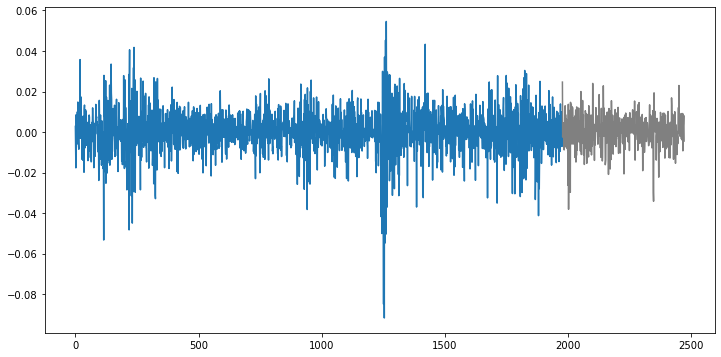

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(y_train_df.index, y_train_df, label="Training Data")
plt.plot(y_test_df.index, y_test_df, label="Test Data", color='gray')
plt.plot(y_test_df.index, forecast_df, label="ARIMAX Forecast", color='red')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Log Return")
plt.title("ARIMAX Model Forecast vs Actual")
plt.show()